# Lab 3: Pretraining a GPT model

This lab is about pretraining large language models. You will work through the full pretraining process for a GPT model, explore different settings, and implement optimisations that make training more efficient. You will also reflect on the impact of data curation on the quality of the pretrained model. By the end of the lab, you will have a solid understanding of how large language models are trained from scratch.

*Tasks you can choose for the oral exam are marked with the graduation cap 🎓 emoji.*

In [1]:
import math
import os
import time
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from gpt2 import Config, Model

## Part 1: Pretraining pipeline

The GPT pretraining pipeline builds on the basic training loop for neural language models you have seen before, but includes several enhancements that improve stability and efficiency when training large models:

* It uses the [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) optimiser with weight decay instead of vanilla stochastic gradient descent.
* It implements a cosine decay learning rate schedule with a linear warmup phase.
* It accumulates gradient updates across multiple batches to allow training with larger effective batch sizes.
* It uses gradient clipping to prevent exploding gradients.

### Training configuration

We begin by setting up a configuration object that defines the key parameters of the training process. The original 124M-parameter GPT-2 model was trained on WebText, a private dataset with 300B tokens of Internet data. Our training pipeline is configured to train a Chinchilla-optimal version of the same model using the [FineWeb-Edu](https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu) dataset and a single A100 GPU with 80GB of memory.

In [2]:
@dataclass
class TrainingConfig:
    device: torch.device = torch.device("cuda")
    shard_dir: str = "data"
    
    # Training steps and data processing
    n_steps: int = 4768 # The total amount of optimization steps during training
    n_tokens_per_step: int = 524288 # The number of tokens in a single step
    batch_size: int = 16 #64 # The size of each batch which is training examples prossessed before parameters are updated.
    sequence_len: int = 1024 # The number of input tokens in the language model.
    n_vocab: int = 50304 # The number of unique tokens.

    # Optimisation and learning rate scheduling
    weight_decay: float = 0.1 # The factor variable for weight decay regularization.
    max_lr: float = 6e-4 # The maximum learning rate
    min_lr: float = 6e-5 # The minimum learning rate
    n_warmup_steps: int = 715 # Number of steps it takes to reach the first max learning rate before cosine decay on learning rate
    n_decay_steps: int = 4053 # The amount of steps during the cosine decay on learning rate
    betas: tuple[float, float] = (0.9, 0.95) # Beta coefficients for the adamw optimizer
    clip_norm: float = 1.0 # The maximum length of the norm of a vector with gradients before the gradient starts to be scaled down.

- sequence_len = 1024
- batch_size = 64 (micro-batch)
- n_tokens_per_step = 524288 (macro-batch)

So:
- Each micro-batch processes:  
  64  sequences * 1024 tokens per sequence = 65,536  tokens
- To reach macro-batch (n_tokens_per_step = 524288), we need to accumulate gradients from:  
  524,288 / 65,536 = 8 micro-batches.
- Only after these 8 micro-batches (gradient accumulation steps) do you perform a single optimizer step (parameter update).

#### 🎓 Task 3.01: Explaining the training parameters

Your first task is to explain the purpose of the training parameters. Some of them will already be known to you from the lectures, while others will become clear first as you progress through the lab and see how everything fits together. Because of this, it is best to revisit and complete this task towards the end of the lab when you have a full understanding of the training process.

One parameter to note is the vocabulary size (`n_vocab`). The GPT-2 tokeniser has a default vocabulary size of 50,257, but for training on a GPU, it is helpful to use numbers that are more hardware-friendly. Specifically, numbers with many factors of&nbsp;2 can lead to more efficient computation. To achieve this, we set the vocabulary size to 50,304, which is slightly larger than needed but has many factors of&nbsp;2. Note that the extra tokens will not be used in practice — they simply act as placeholders without meaningful embeddings.

######  FEEDBACK:Could you also explain what the sequence_len implies and elaborate more on the weight_decay?
###### SOLUTION:THIS HAS BEEN UPDATED

### Model

Next, we set up the GPT model. Our goal is to match the original training setup of GPT-2 as closely as possible. To do this, we follow the initialisation strategy outlined in the key research papers about GPT ([Radford et al., 2018](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf); [Radford et al., 2019](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf); [Brown et al., 2020](https://arxiv.org/pdf/2005.14165)) as well as the official implementation ([link](https://github.com/openai/gpt-2)). Here is a summary of this strategy:

* Token embeddings → Normal distribution with mean $0$ and variance $0.02$.
* Position embeddings → Normal distribution with mean $0$ and variance $0.01$.
* Weights of the linear layers → Normal distribution with mean $0$ and variance $0.02$.
* Biases of the linear layers → Initialised to zeros.
* Weight sharing between the final linear layer and the token embedding.

#### 🎈 Task 3.02: Initialising the model

Expand the skeleton code below to create a fresh model and initialise it according to the GPT-2 strategy.

In [3]:
def configure_model(config: TrainingConfig) -> Model:
    # TODO: Replace the following line with your own code
    model = Model(Config(n_vocab=config.n_vocab))
    mod_dict = model.state_dict()

    for param in mod_dict.keys():
        if param.startswith("wte"):
            nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.02))
        elif param.startswith("wpe"):
            nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.01))
        elif param.endswith("c_proj.weight"):
            # task 3.03 step 3
            nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.02) * (1/math.sqrt(model.config.n_layer * 2))) # Factor for residual intitialization
        elif param.endswith("weight"):
            nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.02))
        elif param.endswith("bias"):
            nn.init.zeros_(mod_dict[param])
    model.lm_head.weight = model.wte.weight
    return model
model = configure_model(TrainingConfig)

/tmp/ipykernel_1049908/2671198488.py:8: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.02))
/tmp/ipykernel_1049908/2671198488.py:10: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.01))
/tmp/ipykernel_1049908/2671198488.py:15: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.02))
/tmp/ipykernel_1049908/2671198488.py:13: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.02) * (1/math.sqrt(model.config.n_layer * 2))) # Factor for residual intitialization


#### Scaled residual initialisation

There is one important detail in the GPT-2 initialisation strategy that we have not addressed yet. [Radford et al. (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) write (Section&nbsp;2.3):

> A modified initialization which accounts for the accumulation on the residual path with model depth is used. We scale the weights of residual layers at initialization by a factor of $1/\sqrt{N}$ where $N$ is the number of residual layers.

Why is this necessary? One of the challenges in training large language models is controlling the variance of activations. However, there are two points in the GPT architecture where variance can grow uncontrollably: the residual connections after the multi-head attention and the MLP. Since these connections simply add activations from previous layers, their variances increases with depth. To see this, note that if we sum $N$ independent normally distributed variables with variance $\sigma^2$, the result has variance $N \sigma^2$. The factor $1/\sqrt{N}$ compensates for this growth.

#### 🎓 Task 3.03: Implementing the scaled residual initialisation

**Step&nbsp;1.** Suppose each summand in a sum of $N$ independent normally distributed variables with variance $\sigma^2$ is scaled by a factor of&nbsp;$k$. The total variance then becomes $N k^2 \sigma^2$. What happens to the total variance if we choose $k = 1/\sqrt{N}$, as in GPT-2?

##### SOLUTION FO STEP 1:

If $k = 1/\sqrt{N}$, the total variance stays the same as a single summand’s variance.

This is because Total variance = $ N (1/\sqrt{N})^2 \sigma^2 = N (1/{N}) \sigma^2 = \sigma^2$

This means that by $1/\sqrt{N}$, we ensure that when we sum $N$ “residual paths,” we don't keep increasing the net variance layer after layer which stabilizes the forward pass.

**Step&nbsp;2.** Test the mathematical theory with a simulation. Generate normally distributed activations using `torch.randn()`. Sum the activations across $N$ hypothetical residual layers, first without scaling and then with the $1/\sqrt{N}$ adjustment. Compare the two cases by producing a plot showing the variance at each layer. To compute the variance of a tensor, use `torch.var()`.



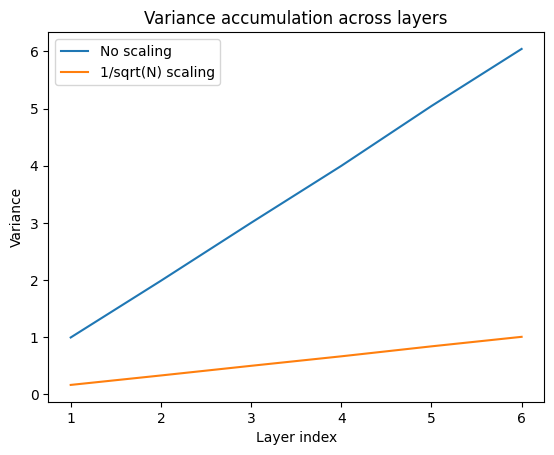

In [4]:
import torch
import matplotlib.pyplot as plt

num_layers=6
num_samples=10000
sums_no_scale = torch.zeros(num_samples)
sums_scaled   = torch.zeros(num_samples)
vars_no_scale = []
vars_scaled   = []

for i in range(1, num_layers + 1):
    new_activations = torch.randn(num_samples)
    
    # 1 NO scaling
    sums_no_scale += new_activations
    vars_no_scale.append(sums_no_scale.var())
    
    # 2 with 1/sqrt(N) scaling
    # scale each new activation by 1/sqrt(num_layers),
    new_activations_scaled = new_activations / (num_layers**0.5)
    sums_scaled += new_activations_scaled
    vars_scaled.append(sums_scaled.var())


# Plot the results
plt.plot(range(1, num_layers + 1), vars_no_scale, label="No scaling")
plt.plot(range(1, num_layers + 1), vars_scaled,   label="1/sqrt(N) scaling")
plt.xlabel("Layer index")
plt.ylabel("Variance")
plt.title("Variance accumulation across layers")
plt.legend()
plt.show()


**Step&nbsp;3.** Update your model initialisation from the previous task to include the scaled residual initialisation. The adjustment should only be applied to the linear layer at the end of the multi-head attention and MLP blocks (`c_proj`). Note that a GPT model with $L$&nbsp;layers has $N = 2 L$ residual layers, because there are two residual connections in each layer (after the multi-head attention and the MLP).

### Data

As mentioned before, GPT-2 was pretrained on a 300B non-public dataset collected by OpenAI. Our pretraining data comes from the public [FineWeb-Edu](https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu) dataset. The full dataset contains 1.3&nbsp;trillion tokens, but here, we will only work with a small sample. We have preprocessed the data by tokenising it with the GPT-2 tokeniser and storing the token indices in equal-sized NumPy arrays, which we call **shards**. The function below loads these shards from a given directory and yields them as PyTorch tensors.

In [5]:
def shards(shard_dir: str):
    for shard in sorted(os.listdir(shard_dir)):
        yield torch.from_numpy(np.load(os.path.join(shard_dir, shard)).astype(np.int64))

In total, our training data consists of 300M tokens:

In [6]:
sum(s.numel() for s in shards("/courses/TDDE09/labs/lab3/data"))

300000000

#### 🎓 Task 3.04: Batching the data

Implement a function `make_batches()` that packages the token indices in the shards into pairs of input and output batches suitable for language modelling training. One efficient way to do this is sketched in the cell below:

In [7]:
shard = torch.tensor(range(15), dtype=torch.long)

# Suppose we want to package the tokens in this shard into batches of shape (2, 3).

# Step 1: Segment the shard into overlapping chunks of size 2 * 3 + 1
chunk1 = shard[0:7]
chunk2 = shard[6:13]
excess = shard[12:]

# Step 2: Create batches from all but the last and all but the first token in each chunk
x1, y1 = chunk1[:-1].view(2, 3), chunk1[1:].view(2, 3)
x2, y2 = chunk2[:-1].view(2, 3), chunk2[1:].view(2, 3)

print(x1)
print(y1)
print(x2)
print(y2)


tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[ 6,  7,  8],
        [ 9, 10, 11]])
tensor([[ 7,  8,  9],
        [10, 11, 12]])


The following code cell shows the signature of `make_batches()`.

In [8]:
def make_batches(config: TrainingConfig):
    # TODO: Replace the following line with your own code
    offset = 0
    num_arg_batch = config.batch_size * config.sequence_len
    excess = torch.tensor([],dtype=torch.long)
    for s in shards("/courses/TDDE09/labs/lab3/data"):
        batch_nr = 0
        print("hello!")
        while True:
            if len(excess) > 0:
                offset = len(excess)

            chunk1_upper_limit = (batch_nr + 1) * num_arg_batch + 1 - offset
            
            if chunk1_upper_limit > len(s):
                excess = s[batch_nr * num_arg_batch - offset:]
                
                break
            else:
                if len(excess) > 0:
                    chunk1 = torch.concatenate((excess, s[batch_nr * num_arg_batch : chunk1_upper_limit]))
                    excess = torch.tensor([],dtype=torch.long)
                    print("Excess", len(excess))
                else:
                    chunk1 = s[batch_nr * num_arg_batch - offset : chunk1_upper_limit]

                x1, y1 = chunk1[:-1].view(config.batch_size, config.sequence_len), chunk1[1:].view(config.batch_size, config.sequence_len)
                yield x1, y1
                
            batch_nr += 1

config = TrainingConfig()
count = 0
for i in make_batches(config):
    #print(i[1].shape)
    count += 1
print(count)

hello!
hello!
Excess 0
hello!
Excess 0
18310


**Hints and considerations:**

* Batches can stretch across shards. You will have to carry over excess tokens at the end of shards to the next batch.
* All batches should have the same shape. Drop excess tokens at the end of the last shard.
* The correct number of batches of shape $(64, 1024)$ for the training shards is $4577$.

#### solution for the task 3.04
The reason for the differences in batches in our case is that used a batch size of 2 to get training to run. So if we divide 146484 with 32 we get 4577.625, were the excess would be not be included making the amount of batches 4577.

### Optimiser

The code in the cell below configures the [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) optimiser. It uses weight decay on all parameters with two or more dimensions (e.g., weights in linear layers), and no decay on the remaining parameters. If the model is on a CUDA device, the code uses the “fused” implementation of the optimiser for efficiency.

In [9]:
def configure_optimizer(model: Model, config: TrainingConfig):
    params = [p for p in model.parameters() if p.requires_grad]
    decay_params = [p for p in params if p.dim() >= 2]
    no_decay_params = [p for p in params if p.dim() < 2]
    param_groups = [
        {"params": decay_params, "weight_decay": config.weight_decay},
        {"params": no_decay_params, "weight_decay": 0.0},
    ]
    return torch.optim.AdamW(
        param_groups,
        lr=config.max_lr,
        betas=config.betas,
        fused=(config.device.type == "cuda"),
    )

#### 🎓 Task 3.05: Exploring the beta parameters

The AdamW optimiser is controlled by two hyperparameters $\beta_1$ and $\beta_2$:

* $\beta_1$ controls the moving average of past gradients.
* $\beta_2$ controls the moving average of past squared gradients, which affects the adaptive learning rate scaling.

Lower values correspond to reduced effect of the respective average, that is, less smoothing and faster adaptation to recent values. In this task, you will explore how different beta values affect the convergence behaviour of the optimiser.

The code below applies the optimiser to the function $f(x) = (x-2)^2 + (y+3)^2$, which has a global minimum at $(2, -3)$. The code yields the trajectories of the parameter values $(x, y)$ visited by Adam when started at $(-4, 5)$ for different values of&nbsp;$\beta_1$ and $\beta_2$.

In [10]:
def adam_trajectories(betas):
    def loss_function(x, y):
        return (x - 2) ** 2 + (y + 3) ** 2

    for beta1, beta2 in betas:
        x = torch.tensor([-4.0], requires_grad=True)
        y = torch.tensor([5.0], requires_grad=True)
        optimizer = torch.optim.AdamW((x, y), lr=0.125, betas=(beta1, beta2))
        trajectory = []
        for _ in range(100):
            optimizer.zero_grad()
            loss = loss_function(x, y)
            loss.backward()
            optimizer.step()
            trajectory.append((x.item(), y.item()))
        yield trajectory, f"β₁ = {beta1}, β₂ = {beta2}"

 Your task is to visualise different trajectories in a plot and analyse the results. Proceed as follows:

* Start by plotting the trajectory for the default values for $\beta_1$ and $\beta_2$. (Consult the PyTorch documentation to find these.)
* Add the plot for the beta values used in our training configuration. For this simple example, do you see a significant difference?
* Add more plots to see what happens if the beta values are too high or too low.

### solution for 3.05:
There is no significant difference between the two results that we got. However, with the training configuration, the trajectories overshooted a bit.
We also did another test for fun with two much smaller values that overshooted by alot but also probably got the closes result to the global minimum.

(0.9, 0.95)
[(-3.869999885559082, 4.868749618530273), (-3.740241765975952, 4.737722396850586), (-3.6107797622680664, 4.606956958770752), (-3.481668710708618, 4.4764933586120605), (-3.35296630859375, 4.346372604370117), (-3.2247302532196045, 4.216635704040527), (-3.0970211029052734, 4.087325096130371), (-2.9698984622955322, 3.9584827423095703), (-2.84342360496521, 3.830150842666626), (-2.717658042907715, 3.702371597290039), (-2.5926642417907715, 3.5751872062683105), (-2.4685051441192627, 3.4486403465270996), (-2.345243215560913, 3.322772979736328), (-2.2229416370391846, 3.197627067565918), (-2.101663112640381, 3.073244094848633), (-1.9814705848693848, 2.949664831161499), (-1.8624260425567627, 2.826930046081543), (-1.744591474533081, 2.7050795555114746), (-1.6280277967453003, 2.584153175354004), (-1.512795329093933, 2.464189052581787), (-1.3989530801773071, 2.3452248573303223), (-1.2865592241287231, 2.22729754447937), (-1.1756703853607178, 2.110442876815796), (-1.0663421154022217, 1.9946

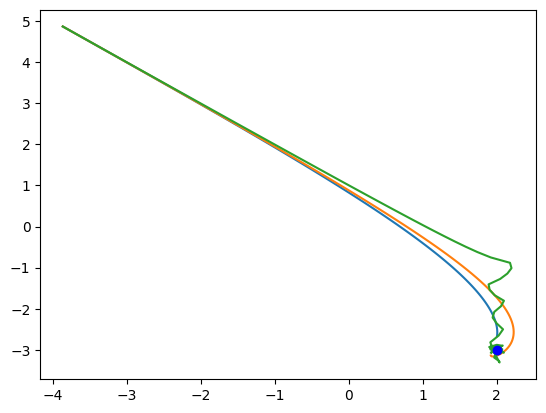

In [11]:
training_config = TrainingConfig()
print(training_config.betas)
betas = training_config.betas
a = torch.tensor(((0.9,0.999),betas,(0.5,0.1)))
#print(a)
from matplotlib import pyplot as plt

plt.figure()

for a_t in adam_trajectories(betas=a):
    print(a_t[0])
    x,y = zip(*a_t[0])
    plt.plot(x,y)
    plt.plot(2,-3,"o",c="b")
    
plt.show()



### Learning rate scheduling

Your next task is to implement the learning rate scheduler. As mentioned before, GPT-2 is trained with cosine decay from a maximum to a minimum learning rate in conjunction with a linear warmup phase.

#### 🎓 Task 3.06: Implementing cosine decay

Implement a function `get_lr_factor()` that determines the learning for a given `step`. To work with the rest of the implementation, this function should return its result as a factor of the maximum learning rate. In particular, the result at the end of the linear warmup should be&nbsp;$1$. Validate your implementation by plotting the function against the training steps.

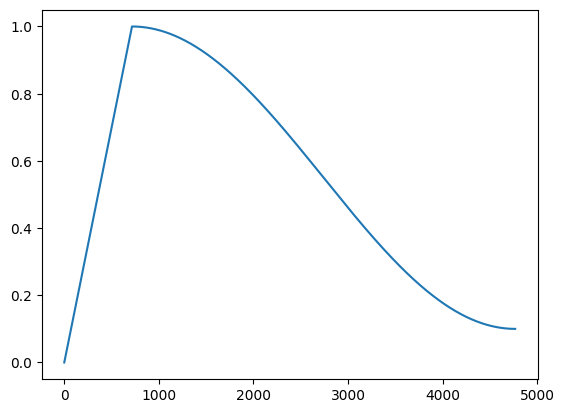

In [12]:
def get_lr_factor(step: int, config: TrainingConfig) -> float:
    # TODO: Replace the next line with your own code
    if step < config.n_warmup_steps:
        return (step/config.n_warmup_steps)
    elif step < config.n_warmup_steps + config.n_decay_steps:
        # how far we are into the decay
        x = (step - config.n_warmup_steps) / config.n_decay_steps
        # The final factor at end of cosine decay
        final_factor = config.min_lr / config.max_lr
        
        # Scaled cosine decay from 1 down to the final factor
        return final_factor + (1/2) * (1 - final_factor) * (1 + math.cos(math.pi * x))      

steps = []
for step in range(config.n_steps):
    steps.append(get_lr_factor(step, config))

plt.plot(steps)
#plt.yscale("log")
plt.show()

**Hint:** For $x \in [0, 1]$, the relevant cosine decay is described by the term $\frac{1}{2} \cdot (1 + \text{cos}(\pi x))$.

### Training loop

At this point, we have everything in place to put together a first version of the training loop. Here it is:

In [13]:
import time
torch.set_float32_matmul_precision(precision="high")
def train(config: TrainingConfig):
    model = configure_model(config)
    model = model.to(config.device)
    model = torch.compile(model)
    batches = make_batches(config)
    optimizer = configure_optimizer(model, config)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda lr: get_lr_factor(lr, config),
    )
    n_micro_steps = config.n_tokens_per_step // (
        config.batch_size * config.sequence_len
    )
    for step in range(config.n_steps):
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        running_loss = 0.0
        for micro_step in range(n_micro_steps):
            x, y = next(batches)
            x, y = x.to(config.device), y.to(config.device)
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                logits = model(x)
                loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))/n_micro_steps
                loss.backward()
            running_loss += loss.item()
        nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm)
        optimizer.step()
        lr = scheduler.get_last_lr()[0]
        scheduler.step()
        torch.cuda.synchronize()
        print(f"step {step:4d} | loss: {running_loss:.4f} | lr: {lr:.4e} | Ts/s: {config.n_tokens_per_step/(time.time()-start_time)}")

Most of the steps should look familiar from previous labs or earlier tasks in this notebook. However, a few key aspects will be new:

**Moving the model and data to the training device.** The model and each batch are moved to the training device using `.to()`. In our training configuration, `config.device` is an NVIDIA GPU, which supports fast tensor computations.

**Gradient accumulation.** Instead of taking an optimisation step after every batch, we accumulate gradients over multiple batches (“micro-steps”). Each batch contributes to the gradients using `loss.backward()`.

**Gradient clipping.** Before updating weights, the gradients are clipped using `clip_grad_norm_()`. This prevents excessively large updates that could destabilise training. The clipping threshold is set by `config.clip_norm`.

#### 🎓 Task 3.07: Fixing the training loop

Try to train a model by executing the code below:

In [14]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True
train(TrainingConfig())

/tmp/ipykernel_1049908/2671198488.py:8: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.02))
/tmp/ipykernel_1049908/2671198488.py:10: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.01))
/tmp/ipykernel_1049908/2671198488.py:15: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.02))
/tmp/ipykernel_1049908/2671198488.py:13: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  nn.init.normal(mod_dict[param], mean=0, std=math.sqrt(0.02) * (1/math.sqrt(model.config.n_layer * 2))) # Factor for residual intitialization


hello!


W0520 16:35:35.893000 1049908 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


step    0 | loss: 10.9874 | lr: 0.0000e+00 | Ts/s: 11740.933795400488
step    1 | loss: 10.9894 | lr: 8.3916e-07 | Ts/s: 46020.70758322623
step    2 | loss: 10.9814 | lr: 1.6783e-06 | Ts/s: 47780.80198004678
step    3 | loss: 10.9648 | lr: 2.5175e-06 | Ts/s: 47197.01128144733
step    4 | loss: 10.9396 | lr: 3.3566e-06 | Ts/s: 47076.283421575994
step    5 | loss: 10.9133 | lr: 4.1958e-06 | Ts/s: 47965.29520859033
step    6 | loss: 10.8744 | lr: 5.0350e-06 | Ts/s: 48235.07882704233
step    7 | loss: 10.8303 | lr: 5.8741e-06 | Ts/s: 48306.92192321992
step    8 | loss: 10.7746 | lr: 6.7133e-06 | Ts/s: 48246.587600407074
step    9 | loss: 10.7266 | lr: 7.5524e-06 | Ts/s: 48196.906929951525
step   10 | loss: 10.6681 | lr: 8.3916e-06 | Ts/s: 48183.68292395567
step   11 | loss: 10.6137 | lr: 9.2308e-06 | Ts/s: 48121.968786832396
step   12 | loss: 10.5581 | lr: 1.0070e-05 | Ts/s: 48106.88619170862
step   13 | loss: 10.5111 | lr: 1.0909e-05 | Ts/s: 47103.29082412323
step   14 | loss: 10.4413 | l

KeyboardInterrupt: 

You will run into two problems:

**Memory issues.** As mentioned above, the training has been set up for an A100 GPU with 80GB of memory. If you are using a less powerful GPU, you will see an out-of-memory error. To fix this, reduce the batch size to lower the memory load on the GPU. Start by halving the batch size and keep adjusting it until you find the largest batch size that fits on your GPU. (You may have to restart the Jupyter kernel to reset the GPU.)

**High losses.** The training losses start at very high values. Recall that the model’s goal is to predict the next token. At the start, the model’s weights are random, so we expect it to output a uniform distribution over the vocabulary. This means each token should have a probability of $1/V$, where $V$ is the vocabulary size. Given this, what should the initial loss be? Think about the cross-entropy loss for a uniform distribution.

#### solution for the task 3.07:
When we tested with different batch sizes (just for testing):
- 8 - ~ 700
- 12 - ~500
- 16 - ~350

To calculate cross entropy loss we first need to look at the formula: sum(ln(1/q(x)) * p(x)). Since we know that q(x) is uniformly distributed, and that p(x) = 1 when summed over the vocabulary. We get that the loss should be ln(1/vocab_size) * 1 = (ln(1) - ln(1/50304)) * 1 = 0 - ln(1/50304) = 10,82... Which is the answer we get after fixing the gradient accumulation.

(You will fix the problem with the high losses in the next task.)

#### 🎓 Task 3.08: Fixing the gradient accumulation

The gradient accumulation in the `train()` function is not implemented correctly. To see this, consider the following example. We set up a linear layer and pass in some random input of shape $[2, 3]$. First, we compute the loss and gradients in the normal way. Then, we do the same thing using gradient accumulation over two singleton batches, in the way this is implemented in `train()`. As you will see, the two outputs are different.

In [15]:
def accumulation_example():
    # Set up a simple model and simulate some input
    model = nn.Linear(3, 2)
    x = torch.randn(2, 3)
    y = torch.randint(0, 2, (2,))

    # Compute the gradient on the complete input
    model.zero_grad()
    output = model(x)
    loss = F.cross_entropy(output, y)
    loss.backward()
    print(model.weight.grad)

    # Compute the gradient using micro-batches (flawed)
    model.zero_grad()
    for i in range(2):
        output = model(x[i : i + 1])
        loss = F.cross_entropy(output, y[i : i + 1])/2# /2 devided by the microbatch size while calculating the loss before backpropagation.
        loss.backward()
    print(model.weight.grad)


accumulation_example()

tensor([[-0.0380, -0.3504, -0.4026],
        [ 0.0380,  0.3504,  0.4026]])
tensor([[-0.0380, -0.3504, -0.4026],
        [ 0.0380,  0.3504,  0.4026]])


Your task is to fix the flawed implementation of gradient accumulation in the training loop.

1. Propose a fix for the problem illustrated in the example.
2. Validate your proposal by modifying the example.
3. Once you are convinced that your fix is correct, apply it to the training loop.
4. How does the fix affect the loss?

### SOLUTION TO TASK 3.08 :
Fix is to devide the loss by the number of micro_steps in a minibatch before backpropagation when calculating the cross entropy loss. The fix seem to make the loss equivalent with the one obtained by the gradient descent on the complete input.

## Part 2: Efficiency optimisations

Training large language models from scratch is a computationally intensive task. Efficient training not only speeds up model convergence but also reduces hardware costs and energy consumption. As models grow in size, optimising the training process becomes increasingly important to ensure that resources are used effectively. In the second part of this lab, we will look into a few such optimisation techniques.

#### 🎓 Task 3.09: Profiling the training loop

Before we explore optimisations, we first need a way to measure training speed. We will define training speed as the **number of tokens processed per second**. Your task is to implement this measurement in the training loop.

**Step&nbsp;1.** Keep track of the number of tokens processed in each optimisation step.

**Step&nbsp;2.** Add a timer to measure the time taken per step. For accurate results, call `torch.cuda.synchronize()` before stopping the timer. This ensures all GPU computations finish before recording the time.

Once you have added this measurement, train the model for a few steps and answer the following questions:

* Based on your measured training speed, how long would it take to train on all data (300M tokens)?
* How much data and time would be required to train a Chinchilla-optimal version of the model?

#### solution for task 3.09 :
Based on the numbers we got, it would take more than 6 hours to process all 300M tokens.

A chinchilla optimal model would require ~20 tokens/parameter to train on. This means that the total amount of training data would be equal to 2.5 Billion tokens (with the model having ~125M parameters). Meaning that for us, it would take 50 hours to train.

###### FEEDBACK:To print the total time taken for the training, I think that you wanted to use the variable “totalStartTime” instead of “startTime”. I don’t see your answers to the final questions
###### SOLUTION:this has been updated

### Floating-point representations

One of the optimisations we can make when training large language models is choosing an appropriate floating-point representation. A floating-point number is represented using three components: a **sign bit**, an **exponent**, and a **fraction** (also called mantissa). The number of bits assigned to the exponent determines the *range* of the representation, while the number of bits in the fraction determines the *precision*.

The most commonly used floating-point format is single-precision floating point (fp32), which uses 1&nbsp;sign bit, 8&nbsp;exponent bits, and 23&nbsp;fraction bits. However, most deep learning computations do not require the full 23-bit precision of fp32. As a result, modern hardware supports lower-precision formats that improve performance and memory efficiency while maintaining training stability. We are particularly interested in two of those:

**TensorFloat-32 (tf32)** is a precision format introduced by NVIDIA. It keeps the same 8-bit exponent as fp32, preserving the same numerical range. However, tf32 reduces the fraction size to 10 bits, leading to lower precision but faster matrix multiplications on dedicated GPUs.

**Brain Floating Point 16 (bf16)** is another reduced precision format widely used in NVIDIA GPUs. Like tf32, bf16 has the same 8-bit exponent as fp32, and therefore, the same range. However, bf16 has only 7 bits for the fraction. Unlike tf32, which is primarily used for internal computations, bf16 can be directly stored and used for activations, weights, and gradients, which can save memory (16 bits per value instead of 32).

#### 🎈 Task 3.10: Exploring floating-point representations

Your task is to rewrite the training loop to take advantage of specialised floating-point representations.

**Step&nbsp;1.** By default, PyTorch uses the fp32 format for internal computations (“highest precision”). Read the documentation of [`torch.set_float32_matmul_precision()`](https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html) to find out how to change this default and use tf32 if possible.

**Step&nbsp;2.** Computing the forward pass and the loss requires even less precision than other parts of the training loop. Read the documentation of [`torch.autocast()`](https://pytorch.org/docs/stable/amp.html#torch.autocast) to find out how to execute these operations using the bf16 format.

**Step&nbsp;3.** Repeat your profiling experiments with the modified training loop. How much time would be required to train the model now that you have implemented the floating-point optimisations?

#### SOLUTION FOR TASK 3.10 :
After the floating point optimizations the time to process all 300M tokens would be 1,89 hours.

### Just-in-time compilation

The second optimisation we will explore is **just-in-time (JIT) compilation** – a technique to speed up code by compiling it at runtime, rather than before execution. This allows the compiler to optimise the code dynamically based on actual inputs and hardware conditions.

PyTorch provides a function [`torch.compile()`](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) that uses JIT compilation to automatically optimise deep learning models. Instead of executing PyTorch operations one by one, this function analyses the computation, restructures it, and generates highly efficient machine code. This optimised code can often be run as a single fused operation on the GPU.

The performance boost from JIT compilation is especially noticeable on high-end GPUs like the NVIDIA A100 or H100, but it can still provide smaller speedups on less powerful GPUs.

#### 🎈 Task 3.11: Exploring just-in-time compilation

In this task, you will measure how much `torch.compile()` improves the training speed of the GPT-2 model. To enable JIT compilation, add the following line to the training loop:

```
model = torch.compile(model)
```

Make sure to place this *after* moving the model to the training device so the optimisation can be tailored to the hardware you are using. Once you have enabled JIT compilation, rerun your profiling experiments and compare the training speed before and efter.


##### Answer:
In total we have 300 million tokens to train on
We process 524288 in each step. This means that we have 300 000 000/524288 which is ~572,2 which is the amount of steps it takes to complete an epoch.

In training, we have 4768 steps, which is combined with the result above to get the amount of epochs for training, which is ~8.33...
We calculated the time to process all 300M tokens to be ~1.74 hours with the JIT compilation.

The final answer we get is 1.74*8.33 = ~14.5 hours for the total training

## Part 3: Evaluate the pre-trained model

This notebook contains all the code needed to train a GPT-2 model on the FineWeb-Edu dataset. However, training on the full dataset is not practical within the time and resource limits of this lab.

To save time, we provide a pretrained model that was trained using the exact same settings you developed earlier. The only difference is that we used a compute node with 8 NVIDIA A100 GPUs (80GB each). With this setup, a full Chinchilla-optimal training run takes about 30 minutes.

We provide the trained model in the file `gpt-2-fineweb-edu.pt`. You can load it with the following code:

In [16]:
pretrained = Model(Config(n_vocab=50304))
pretrained.load_state_dict(torch.load("/courses/TDDE09/labs/lab3/gpt-2-fineweb-edu.pt"))
pretrained.lm_head.weight = pretrained.wte.weight

#### 🎓 Task 3.12: Evaluating the pretrained model

The next cell contains code for evaluating the FineWeb-Edu model on the same small sample from the [HellaSwag](https://rowanzellers.com/hellaswag/) benchmark you already used in lab&nbsp;2. How does its score compare to that of the original GPT-2 model? What does this result tell you about the impact of data quality on the downstream performance of language models?

### solution for taks 3.12 :
The result from this lab is 0.78 points lower than the original GPT-2 model.

We assume that the pretraining for GPT-2 in lab 2 used 300B tokens for pretraining.

This shows how important the quality of the data is. With much less data, the model on lab 3 successfully scored very close to the model from lab 2 which was based on OpenAIs training.

FineWeb-Edu Model Performance:
- The FineWeb-Edu model achieves 29.69% accuracy, which is slightly lower than the original GPT-2 model's performance.
- This suggests that the FineWeb-Edu dataset, while focused on educational content, may not have provided enough diversity or quality to outperform the original GPT-2 model on the HellaSwag benchmark.


Impact of Data Quality:
- Data Diversity: The original GPT-2 was trained on a diverse dataset (WebText), which includes a wide range of topics and styles. This diversity likely helps the model generalize better to tasks like HellaSwag,          which requires commonsense reasoning across various contexts.
- Data Quality: FineWeb-Edu is focused on educational content, which may be more specialized and less diverse. While this could improve performance on educational tasks, it may not generalize as well to broader           benchmarks like HellaSwag.
- Task-Specific Performance: The HellaSwag benchmark tests commonsense reasoning, which may not align perfectly with the educational focus of FineWeb-Edu. This could explain the slightly lower performance

In [17]:
import json

import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

with open("hellaswag-mini.jsonl") as f:
    n_correct = 0
    n_total = 0
    for line in f:
        sample = json.loads(line)
        prefix = tokenizer.encode(sample["ctx"])
        ending_scores = []
        for i, ending in enumerate(sample["endings"]):
            suffix = tokenizer.encode(" " + ending)
            context = torch.tensor([prefix + suffix], dtype=torch.long)
            with torch.no_grad():
                logits = pretrained(context)
                ending_score = torch.nn.functional.cross_entropy(
                    logits[0, -len(suffix) - 1 : -1], context[0, -len(suffix) :]
                )
            ending_scores.append((ending_score, i))
        predicted = min(ending_scores)[1]
        n_correct += int(predicted == sample["label"])
        n_total += 1
    print(f"Accuracy: {n_correct / n_total:.2%}")

Accuracy: 29.69%


###### Feedback:Could you elaborate a bit more on your answer?
###### solution :this feedback has been updated

**🥳 Congratulations on finishing lab&nbsp;3!**